In [2]:
import torch
# from transformers import MT5ForConditionalGeneration, AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import gradio as gr

In [3]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load the fine-tuned T5 model
fine_tuned_model_path = "/soe/npullabh/244_final_project/t5/t5_fine_tuned.pt"
fine_tuned_tokenizer = "/soe/npullabh/244_final_project/t5/t5_tokenizer"
model = T5ForConditionalGeneration.from_pretrained(fine_tuned_model_path)
tokenizer = T5Tokenizer.from_pretrained(fine_tuned_tokenizer)

In [7]:
# tokenizer = T5Tokenizer.from_pretrained(fine_tuned_tokenizer)
tokenizer_french = T5Tokenizer.from_pretrained(fine_tuned_tokenizer, source_lang="fr")
tokenizer_eng = T5Tokenizer.from_pretrained(fine_tuned_tokenizer, source_lang="en")

In [9]:
# fine_tuned_model_path = "/soe/npullabh/244_final_project/t5/mt5_fine_tuned.pt"
# fine_tuned_tokenizer = "/soe/npullabh/244_final_project/t5/mt5_tokenizer"
# model = MT5ForConditionalGeneration.from_pretrained(fine_tuned_model_path)
# mt5_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_tokenizer)

In [10]:
# setup device based on availability
device = "cuda:4" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

Using device: cuda:4


In [11]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [5]:
def generate_suggestions(source_sentence, partial_translation):
    # Combine the source sentence and partial translation into a single input string
    input_string = f"translate French to English: {source_sentence} <<< {partial_translation} >>>"
    print(input_string)
    # Tokenize the input string
    input_ids = tokenizer.encode(input_string, return_tensors='pt').to(device)
    # Generate the translation suggestions
    suggestions = []
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=150, num_beams=5, early_stopping=True)
        # Decode the generated suggestions and return as a list of words
        suggestions = tokenizer.decode(outputs[0], skip_special_tokens=True).split()[:-1]
    return suggestions

In [11]:
source_text = "merci , monsieur segni , je le ferai bien volontiers"
# target_prefix = "thank you, mr segni, i shall do so"
target_prefix = "thank you, mr segni, I shall do gladly"
generate_suggestions(source_text, target_prefix)

translate French to English: merci , monsieur segni , je le ferai bien volontiers <<< thank you, mr segni, I shall do gladly >>>


['thank', 'you,', 'mr', 'segni,', 'i', 'shall', 'gladly', 'do']

In [12]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Generate translation suggestions using the fine-tuned T5 model
    # Experiment 1: beam search
    output = model.generate(
        input_ids=input_ids,
        num_beams=5, 
        max_length=max_length,
        no_repeat_ngram_size=2,
        early_stopping=True,
        num_return_sequences=num_suggestions
    )

#     output = model.generate(
#         input_ids=input_ids,
#         do_sample=True,
#         max_length=max_length,
#         top_k=50,
#         top_p=0.95,
#         num_return_sequences=num_suggestions
#     )

    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
#         suggestion = suggestion[len(target_prefix):].strip().split()
#         print(suggestion)
#         count = 0
#         suggestions += suggestion
#         print("suggestions: ", suggestion)
#         for word in suggestion:
#             word_suggestions.append(word)
#             count += 1
#             if count == words:
#                 break
#         word_suggestions.append(suggestion[-1])
#     print(word_suggestions)
#     print(suggestions)
#     return word_suggestions
#     return suggestions[:words]
#     print(suggestions)
    return suggestions

In [14]:
def generate_translation(source_text, target_prefix="", max_length=50, num_suggestions=5):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer.encode(source_text, return_tensors='pt')
    target_ids = tokenizer.encode(target_prefix, return_tensors='pt')
    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

#     # Generate translation suggestions using the fine-tuned T5 model
#     # Experiment 1: beam search
#     beam_outputs = model.generate(
#         input_ids=input_ids,
#         num_beams=5, 
#         max_length=max_length,
#         no_repeat_ngram_size=2,
#         early_stopping=True,
#         num_return_sequences=num_suggestions
#     )

#     # Decode the generated sequences and remove special tokens
#     top_suggestions = []
#     for beam_output in beam_outputs:
#         output_ids = beam_output.tolist()
#         output_sequence = tokenizer.decode(output_ids, skip_special_tokens=True)
#         next_word = output_sequence.split()[-1]
#         top_suggestions.append(next_word)
#         if len(top_suggestions) == num_suggestions:
#             break
#     return top_suggestions

In [72]:
def generate_translation_for_one_sent(source_text, prefix):
    words = 1
    num_beams = 5
    suggestions = generate_translation(source_text, words, target_prefix=target_prefix, num_suggestions=1)
    # pick the first suggestion
#     print(len(source_text.split()))
#     suggestion = suggestions[0]
    while ((len(source_text.split()) + 5) > len(prefix.split())):
        print("prefix so far: ", prefix, len(prefix.split()))
        suggestions = generate_translation(source_text, words, target_prefix=target_prefix, num_suggestions=1)
        if words < num_beams:
            words += 1
        # pick the first suggestion
#         print((len(source_text.split()) + 5) > len(prefix.split()))
        suggestion = input()
        prefix = prefix + " " + suggestion
        if suggestion == "":
            break
    return prefix

## Experiments

In [16]:
dev_source_text_path = "../data/sup_valid.en-fr.fr"
dev_target_text_path = "../data/sup_valid.en-fr.en"

In [28]:
test_source_text_path = "../data/test.en-fr.fr"
test_target_text_path = "../data/test.en-fr.en"

In [17]:
# read the data from the files and store them in pandas dataframe
def retrieve_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            data.append(line)
    return data

In [18]:
dev_source_sentences = retrieve_data(dev_source_text_path)
dev_target_sentences = retrieve_data(dev_target_text_path)

In [29]:
test_source_sentences = retrieve_data(test_source_text_path)
test_target_sentences = retrieve_data(test_target_text_path)

In [13]:
def truncate_sentences(percent, data):
    partial_prefixes = []
    for sentence in data:
        sentence_tokens = sentence.split()
        sent_len = round(len(sentence_tokens) * percent)
        partial_prefix = ' '.join(sentence_tokens[:sent_len])
        partial_prefixes.append(partial_prefix)
    return partial_prefixes

In [23]:
def prefix_partial_completion(percent):
    partial_prefixes = truncate_sentences(percent, dev_target_sentences)
    predictions = []
    for index, prefix in tqdm(enumerate(partial_prefixes), total=len(partial_prefixes)):
        source_text = dev_source_sentences[index]
        suggestion = generate_translation(source_text, 0, prefix)
        pred = prefix + " " + suggestion[0]
        predictions.append(pred)
    return predictions

In [12]:
def find_blue_score_for_x_percent_translations(x_percent, preds):
    dev_references = [[target_sent.split()] for target_sent in dev_target_sentences]
    dev_percent_candidates = [pred_sent.split() for pred_sent in preds]
    dev_bleu_percent = corpus_bleu(dev_references, dev_percent_candidates)
    print(f'Dev BLEU score with {x_percent * 100}% partial translation: ', dev_bleu_percent)
    return dev_bleu_percent

In [24]:
predictions_20_percent = prefix_partial_completion(0.2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:58<00:00,  3.71it/s]


In [30]:
def prefix_partial_completion_test(percent):
    partial_prefixes = truncate_sentences(percent, test_target_sentences)
    predictions = []
    for index, prefix in tqdm(enumerate(partial_prefixes), total=len(partial_prefixes)):
        source_text = test_source_sentences[index]
        suggestion = generate_translation(source_text, 0, prefix)
        pred = prefix + " " + suggestion[0]
        predictions.append(pred)
    return predictions

In [31]:
predictions_20_percent_test = prefix_partial_completion_test(0.2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [09:34<00:00,  3.49it/s]


In [32]:
with open('predictions_test.txt','w') as tfile:
    tfile.write('\n'.join(predictions_20_percent_test))

In [33]:
with open('references_test.txt','w') as tfile:
    tfile.write('\n'.join(test_target_sentences))

In [25]:
predictions_20_percent[:5]

['what i would also t we will also have to do in biarritz is look a little further.',
 'we , as elected representatives , are at the duty to encourage them to make progress, despite the fact that we have adversity.',
 'with an eye to the events of recent times, i also think that the question of the essence price is particularly remarkable.',
 'at present , the council is examining the inclusion of such mechanisms in article 7.',
 'secondly , it lies in its transparency for the zens who are now aware of the rights they have to those who apply and develop the european law. it also lies with the people who implement and draw up the law in a european way']

In [26]:
with open('predictions.txt','w') as tfile:
    tfile.write('\n'.join(predictions_20_percent))

In [27]:
with open('references.txt','w') as tfile:
    tfile.write('\n'.join(dev_target_sentences))

#### Experiment 1: beam search

In [117]:
percent = 0.0
predictions_0_percent = prefix_partial_completion(percent)
dev_bleu_0_percent = find_blue_score_for_x_percent_translations(percent, predictions_0_percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:49<00:00,  3.39it/s]


Dev BLEU score with 0.0 partial translation:  0.1937981210087743


In [116]:
percent = 0.10
predictions_10_percent = prefix_partial_completion(percent)
dev_bleu_10_percent = find_blue_score_for_x_percent_translations(percent, predictions_10_percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:45<00:00,  3.42it/s]


Dev BLEU score with 10.0 partial translation:  0.18211390289638116


In [107]:
percent = 0.2
predictions_20_percent = prefix_partial_completion(percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:37<00:00,  3.46it/s]


In [115]:
dev_bleu_20_percent = find_blue_score_for_x_percent_translations(percent, predictions_20_percent)

Dev BLEU score with 20.0 partial translation:  0.24911361844302432


In [112]:
percent = 0.4
predictions_40_percent = prefix_partial_completion(percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:01<00:00,  3.32it/s]


In [114]:
dev_bleu_40_percent = find_blue_score_for_x_percent_translations(percent, predictions_40_percent)

Dev BLEU score with 40.0 partial translation:  0.4104128729595627


In [1]:
bleu_scores = [0.1937, 0.1821, 0.2491, 0.4104]
bleu_scores_rounded = []
for score in bleu_scores:
    score = round(score * 100)
    bleu_scores_rounded.append(score)

In [2]:
bleu_scores_rounded

[19, 18, 25, 41]

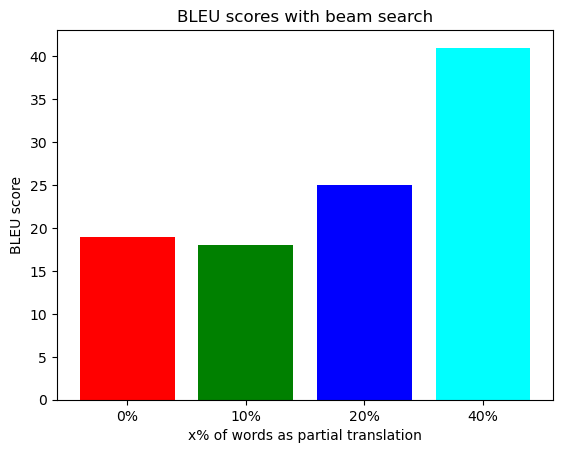

In [3]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, bleu_scores_rounded, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with beam search")

# Show graph
plt.show()

In [81]:
# source_text = "merci , monsieur segni , je le ferai bien volontiers"
# target_prefix = "thank"
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)
# generate_translation_for_one_sent(source_text, target_prefix)

['k you very much for this clarification, commissioner.']


['k you very much for this clarification, commissioner.']

In [19]:
source_text = "merci , monsieur segni , je le ferai bien volontiers"
target_prefix = "thank you, mr y much mr segni segni. segni. sgt."

suggestions = generate_translation(source_text, target_prefix=target_prefix, num_suggestions=5)

print("Translation suggestions:")
for i, suggestion in enumerate(suggestions):
    print(f"{i+1}: {suggestion}")

Translation suggestions:
1: sgt.
2: sgt.
3: sgt.
4: sgt.
5: segni.


In [9]:
def rank_suggestions(input_ids, output):
    # Implement the auto-complete code to rank the suggestions
    # and return a list of ranked suggestions
    suggestions = []
    for sequence in output:
        sequence = sequence[input_ids.shape[-1]:]
        suggestion = tokenizer.decode(sequence)
        suggestions.append(suggestion)
    return suggestions

#### Experiment 2 - random sampling

In [17]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 2: 
    # Random sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=0,
        num_return_sequences=num_suggestions
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [16]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['a great deal of light, commissioner.']

In [15]:
percent = [0.0, 0.1, 0.2, 0.4]
def run_eval(percent):
    scores = []
    for val in percent:
        preds = prefix_partial_completion(val)
        dev_score = find_blue_score_for_x_percent_translations(val, preds)
        scores.append(dev_score)
    return scores

In [2]:
def round_scores(bleu_scores):
    bleu_scores_rounded = []
    for score in bleu_scores:
        score = round(score * 100)
        bleu_scores_rounded.append(score)
    return bleu_scores_rounded

In [28]:
random_sampling_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:51<00:00,  4.24it/s]


Dev BLEU score with 0.0 partial translation:  0.09487372037855815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:09<00:00,  4.66it/s]


Dev BLEU score with 10.0 partial translation:  0.10737419352938729


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:25<00:00,  5.19it/s]


Dev BLEU score with 20.0 partial translation:  0.18728035455535916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:26<00:00,  4.48it/s]


Dev BLEU score with 40.0 partial translation:  0.3743397749400694


In [33]:
bleu_scores = [0.09487372037855815, 0.10737419352938729, 0.18728035455535916, 0.3743397749400694]
random_sampling_scores = round_scores(bleu_scores)

In [34]:
random_sampling_scores

[9, 11, 19, 37]

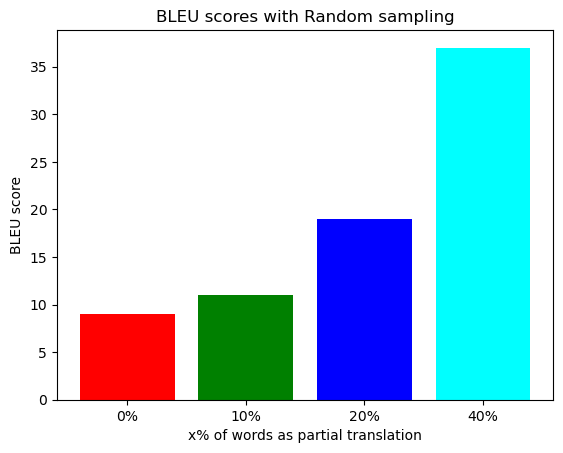

In [37]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, random_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Random sampling")

# Show graph
plt.show()

#### Experiment 3: Top-k sampling

In [38]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 3: 
    # Top-k sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=50
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [39]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['k you very much for this clarification, commissioner.']

In [40]:
percent = [0.0, 0.1, 0.2, 0.4]
topk_sampling_scores = run_eval(percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:11<00:00,  4.07it/s]


Dev BLEU score with 0.0% partial translation:  0.11068094739550842


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:15<00:00,  4.04it/s]


Dev BLEU score with 10.0% partial translation:  0.11363497131692624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:40<00:00,  4.99it/s]


Dev BLEU score with 20.0% partial translation:  0.19757166017977995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:41<00:00,  4.99it/s]


Dev BLEU score with 40.0% partial translation:  0.3772971092010412


In [44]:
bleu_scores = [0.11068094739550842, 0.11363497131692624, 0.19757166017977995, 0.3772971092010412]
topk_sampling_scores = round_scores(bleu_scores)

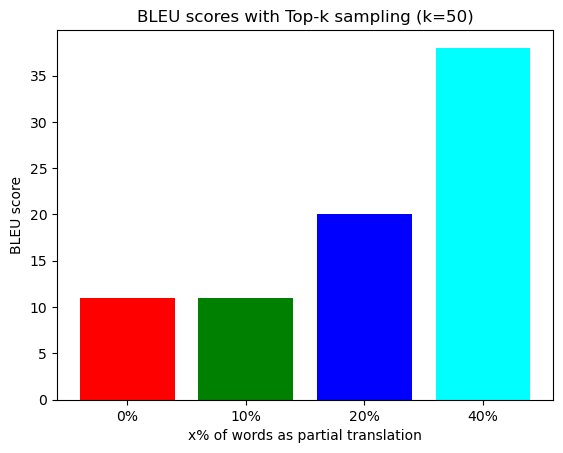

In [45]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, topk_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Top-k sampling (k=50)")

# Show graph
plt.show()

#### Experiment 4: nucleus sampling

In [46]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 4: 
    # nucleus sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_p=0.92, 
        top_k=0
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [47]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['k you very much, commissioner.']

In [48]:
percent = [0.0, 0.1, 0.2, 0.4]
nucleus_sampling_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:36<00:00,  5.05it/s]


Dev BLEU score with 0.0% partial translation:  0.11990266435604813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:41<00:00,  4.98it/s]


Dev BLEU score with 10.0% partial translation:  0.12566208867828282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:39<00:00,  5.00it/s]


Dev BLEU score with 20.0% partial translation:  0.20666815270664768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:43<00:00,  4.96it/s]


Dev BLEU score with 40.0% partial translation:  0.38254461376323623


In [50]:
bleu_scores = [0.11990266435604813, 0.12566208867828282, 0.20666815270664768, 0.38254461376323623]
nucleus_sampling_scores = round_scores(bleu_scores)

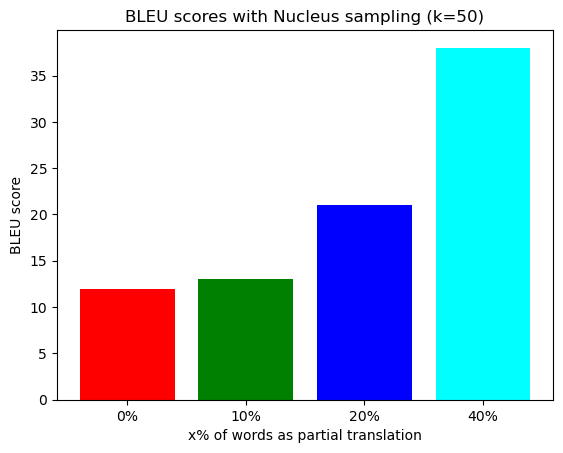

In [51]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, nucleus_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Nucleus sampling (k=50)")

# Show graph
plt.show()

In [13]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 5: 
    # multiple
    output = model.generate(
        input_ids=input_ids,
        do_sample=True,
        max_length=max_length,
        top_k=50,
        top_p=0.95,
        num_return_sequences=num_suggestions
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [17]:
percent = [0.0, 0.1, 0.2, 0.4]
topk_topp_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:32<00:00,  5.10it/s]


Dev BLEU score with 0.0% partial translation:  0.12107021747040947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:34<00:00,  5.07it/s]


Dev BLEU score with 10.0% partial translation:  0.12718631389786647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:35<00:00,  5.06it/s]


Dev BLEU score with 20.0% partial translation:  0.2064257968238083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:42<00:00,  4.97it/s]


Dev BLEU score with 40.0% partial translation:  0.3825580736125818


In [18]:
bleu_scores = [0.12107021747040947, 0.12718631389786647, 0.2064257968238083, 0.3825580736125818]
topk_topp_sampling_scores = round_scores(bleu_scores)

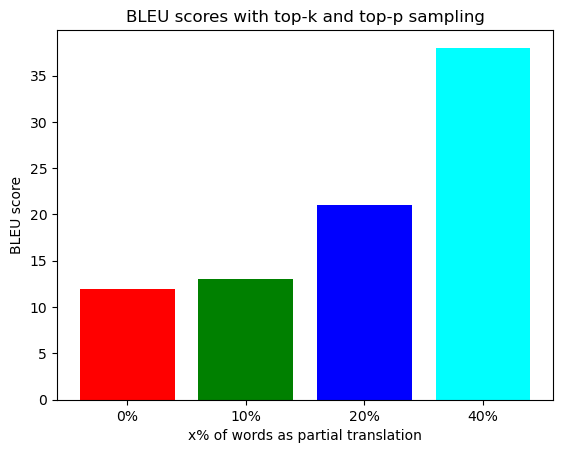

In [22]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, topk_topp_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with top-k and top-p sampling")

# Show graph
plt.show()

In [19]:
percent_0_translations = [0.1937981210087743, 0.09487372037855815, 0.11068094739550842,
                         0.11990266435604813, 0.1210702174704094]
percent_0_translations_rounded = round_scores(percent_0_translations)

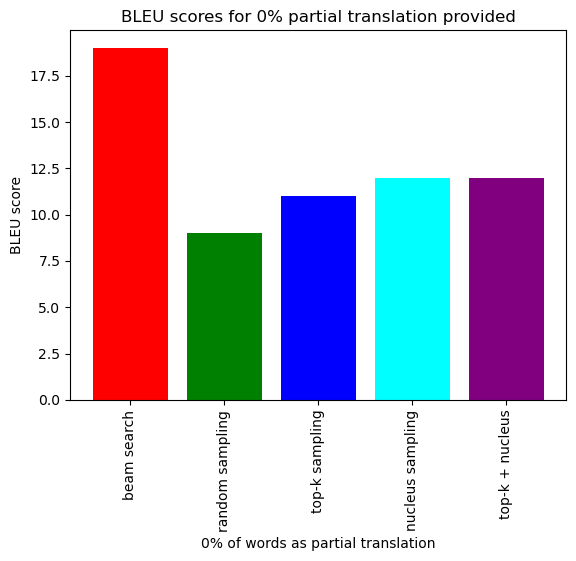

In [30]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_0_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('0% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 0% partial translation provided")

# Show graph
plt.show()

In [22]:
percent_10_translations = [0.18211390289638116, 0.10737419352938729, 0.11363497131692624,
                         0.12566208867828282, 0.12718631389786647]
percent_10_translations_rounded = round_scores(percent_10_translations)

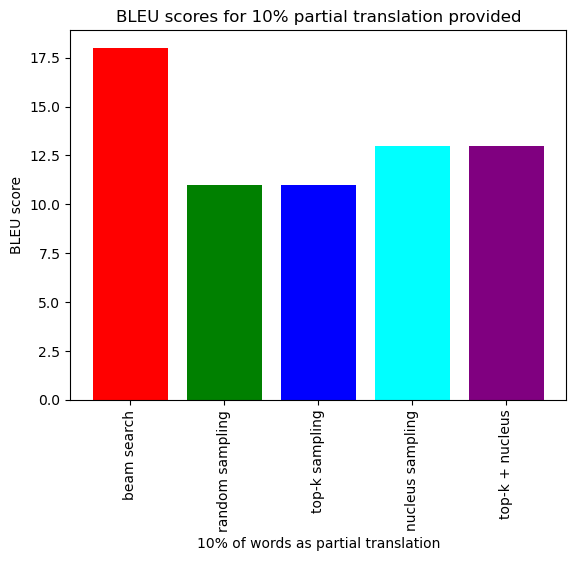

In [31]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_10_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('10% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 10% partial translation provided")

# Show graph
plt.show()

In [26]:
percent_20_translations = [0.24911361844302432, 0.18728035455535916, 0.19757166017977995,
                         0.20666815270664768, 0.2064257968238083]
percent_20_translations_rounded = round_scores(percent_20_translations)

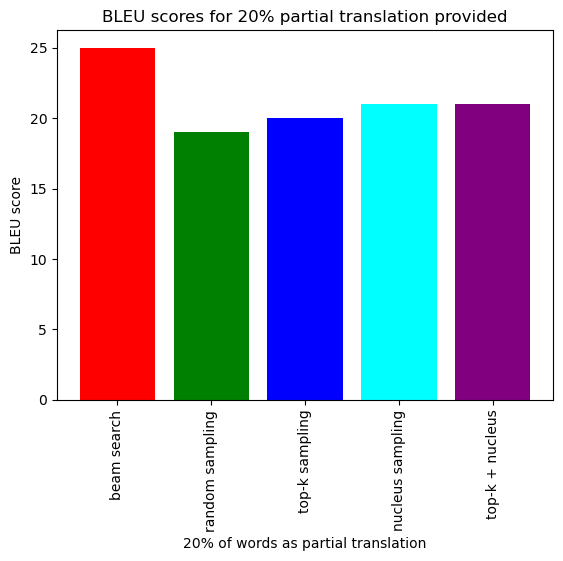

In [32]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_20_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('20% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 20% partial translation provided")

# Show graph
plt.show()

In [28]:
percent_40_translations = [0.4104128729595627, 0.3743397749400694, 0.3772971092010412,
                         0.38254461376323623, 0.3825580736125818]
percent_40_translations_rounded = round_scores(percent_40_translations)

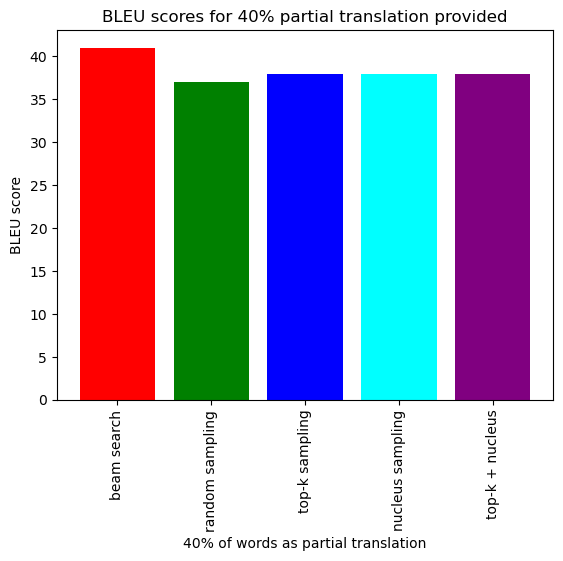

In [33]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_40_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('40% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 40% partial translation provided")

# Show graph
plt.show()